To do tomorrow - run the interpolation and grid alignment. Check the sensitivity for the window for the Z score. Figure out how to repeat the analysis for targeted windows around flagged points.


In [697]:
"""Apply quality control steps to the full set of buoy data.
Quality control steps:
1. Remove duplicated dates
2. Remove duplicated positions
3. Align to an hourly grid (downsampling and aligning, not adding points)
4. Remove points with implied velocity higher than 1.5 m/s
5. Remove points southward of the 95th percentile of sea ice extent
6. Remove isolated data (less than 11 observations within a 24 hour window)
"""

import json
import numpy as np
import os
import pandas as pd
import pyproj
from scipy.interpolate import interp1d
import sys
sys.path.append('../../drifter')
import xarray as xr
import proplot as pplt

from importlib import reload
import utilities.analysis as anls
import utilities.cleaning as clean
import utilities.interpolation as interp
clean = reload(clean)
interp = reload(interp)
anls = reload(anls)
from utilities.analysis import compute_velocity

In [3]:
#### Define QC algorithm ####
def standard_qc(buoy_df,
                min_size=500,
                gap_threshold='6H',                
                segment_length=24,
                lon_range=(-180, 180),
                lat_range=(65, 90),
                verbose=False):
    """QC steps applied to all buoy data. Wrapper for functions in drifter.clean package.
    min_size = minimum number of observations
    gap_threshold = size of gap between observations that triggers segment length check
    segment_length = minimum size of segment to include
    lon_range = tuple with (min, max) longitudes
    lat_range = tuple with (min, max) latitudes
    verbose = if True, print messages to see where data size is reduced
    
    Algorithm
    1. Check for duplicated and reversed dates with check_dates()
    2. Check for duplicated positions with check_positions() with pairs_only set to True.
    3. Check for gaps and too-short segments using check_gaps()
    4. Check for anomalous speeds using check_speed()
    """
    buoy_df_init = buoy_df.copy()
    n = len(buoy_df)
    flag_date = clean.check_dates(buoy_df)
    flag_pos = clean.check_positions(buoy_df, pairs_only=True)
    buoy_df = buoy_df.loc[~(flag_date | flag_pos)].copy()
    if verbose:
        if len(buoy_df) < n:
            print('Initial size', n, 'reduced to', len(buoy_df))

    def bbox_select(df):
        """Restricts the dataframe to data within
        the specified lat/lon ranges. Selects data from the earliest
        day that the data is in the range to the last day the data
        is in the range. In between, the buoy is allowed to leave
        the bounding box."""
        lon = df.longitude
        lat = df.latitude
        lon_idx = (lon > lon_range[0]) & (lon < lon_range[1])
        lat_idx = (lat > lat_range[0]) & (lat < lat_range[1])
        idx = df.loc[lon_idx & lat_idx].index
        return df.loc[(df.index >= idx[0]) & (df.index <= idx[-1])].copy()
        
    buoy_df = bbox_select(buoy_df)

    if verbose:
        if len(buoy_df) < n:
            print('Initial size', n, 'reduced to', len(buoy_df))
    
    # Return None if there's insufficient data
    if len(buoy_df) < min_size:
        print('Observations in bounding box', n, 'less than min size', min_size)
        return None

    flag_gaps = clean.check_gaps(buoy_df,
                                 threshold_gap=gap_threshold,
                                 threshold_segment=segment_length)
    buoy_df = buoy_df.loc[~flag_gaps].copy()
    
    if len(buoy_df) < min_size:
        return None
    else:
        buoy_df_init['flag'] = 1
        buoy_df_init.loc[buoy_df.index, 'flag'] = 0
        return buoy_df_init


In [ ]:
#### Parameters ####
max_speed = 1.5 # m/s
min_size = 24 * 30 # number of observations to equal 30 days of observations
max_gap = '6H'
min_segment = 11 # Need at least this many observations within each centered window

min_lon = -30 # If no data between min_lon, max_lon, then skip
max_lon = 30
min_lat = 65
max_lat = 90

datasets = ['MOSAiC'] # Options: MOSAiC, ACSYS, FRAMZY, IABP, N-ICE


Checking the speed step by step, as done by elipot et al. Advantage here is that speed anomalies get left out. Disadvantage - step by step is pretty slow. I think the backward-forward method gets close to the right idea.

In [672]:
def check_speed(buoy_df, date_index=True, window='3D', sigma=6, max_speed=1.5):
    """If the position of a point is randomly offset from the path, there will
    be a signature in the velocity. The size of the anomaly will differ depending
    on the time resolution. 
    
    Update to check sequentially, or to update if something is masked.
    
    window can be either time or integer, it is passed to the pandas rolling
    method for calculating anomalies. Default is to use 24 observations for the calculations.
    Data near endpoints are compared to 
    
    method will have more options eventually, for now just z score.
    
    In this method, I first calculate a Z-score for the u and v velocity components, using the 
    forward-backward difference method. This method calculates velocity with forward differences and
    with backward differences, and returns the value with the smallest magnitude. It is therefore
    designed to catch when there is a single out-of-place point. Z-scores are calcuted by first 
    removing the mean over a centered period with the given window size (default 3 days), then
    dividing by the standard deviation over the same period. The Z-scores are then detrended by
    subtracting the median over the same window. 
    
    Next, 
    
    """

    buoy_df = buoy_df.copy()
    if date_index:
        date = pd.Series(pd.to_datetime(buoy_df.index.values).round('1min'), index=pd.to_datetime(buoy_df.index))
    else:
        date = pd.to_datetime(buoy_df.date).round('1min')

    window = pd.to_timedelta(window)
    
    n_min = int(0.4*buoy_df.rolling(window, center=True).count()['latitude'].median())
    assert n_min > 0, 'Error: minimum size is' + str(n_min)
    def zscore(df, window, n_min):
        uscore = (df['u'] - df['u'].rolling(window, center=True, min_periods=n_min).mean()) / \
                 df['u'].rolling(window, center=True, min_periods=n_min).std()
        vscore = (df['v'] - df['v'].rolling(window, center=True, min_periods=n_min).mean()) / \
                 df['v'].rolling(window, center=True, min_periods=n_min).std()

        zu_anom = uscore - uscore.rolling(window, center=True, min_periods=n_min).median()
        zv_anom = vscore - vscore.rolling(window, center=True, min_periods=n_min).median()
        
        return zu_anom, zv_anom

    # First calculate speed using backward difference and get Z-score
    df = compute_velocity(buoy_df, date_index=True, method='fb')

    zu_init, zv_init = zscore(df, window, n_min)
    zu, zv = zscore(df, window, n_min)

    # Anytime the Z score for U or V velocity is larger than 3, re-calculate Z
    # scores leaving that value out.
    # Probably should replace with a while loop so that it can iterate a few times
    for date in df.index:
        if (np.abs(zu[date]) > 3) | (np.abs(zv[date]) > 3):
            # Select part of the data frame that is 2*n_min larger than the window
            idx = df.index[np.abs(df.index - date) < (1.5*window)].drop(date)
            df_new = compute_velocity(df.drop(date).loc[idx,:], method='fb')
            zu_idx, zv_idx = zscore(df_new, window, n_min)

            idx = zu_idx.index[np.abs(zu_idx.index - date) < (0.5*window)]
            zu.loc[idx] = zu_idx.loc[idx]
            zv.loc[idx] = zv_idx.loc[idx]

    speed_flag = df.u.notnull() & ((np.abs(zu) > sigma) | (np.abs(zv) > sigma))
    df = compute_velocity(buoy_df.loc[~speed_flag], method='fb')
    if np.any(df.speed > max_speed):
        speed_flag = speed_flag | (df.speed > max_speed)

    return zu, zv, speed_flag

   

In [685]:
buoy_df = clean_data['2019P142']
zu, zv, f = check_speed(buoy_df, window='1D', sigma=4)
f[f]

datetime
2020-04-24 00:30:00    True
dtype: bool

/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


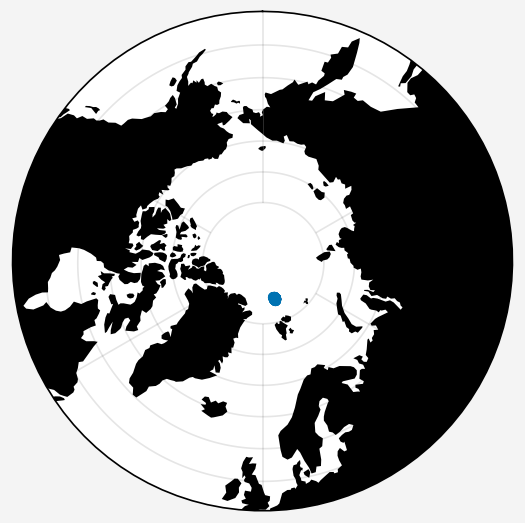

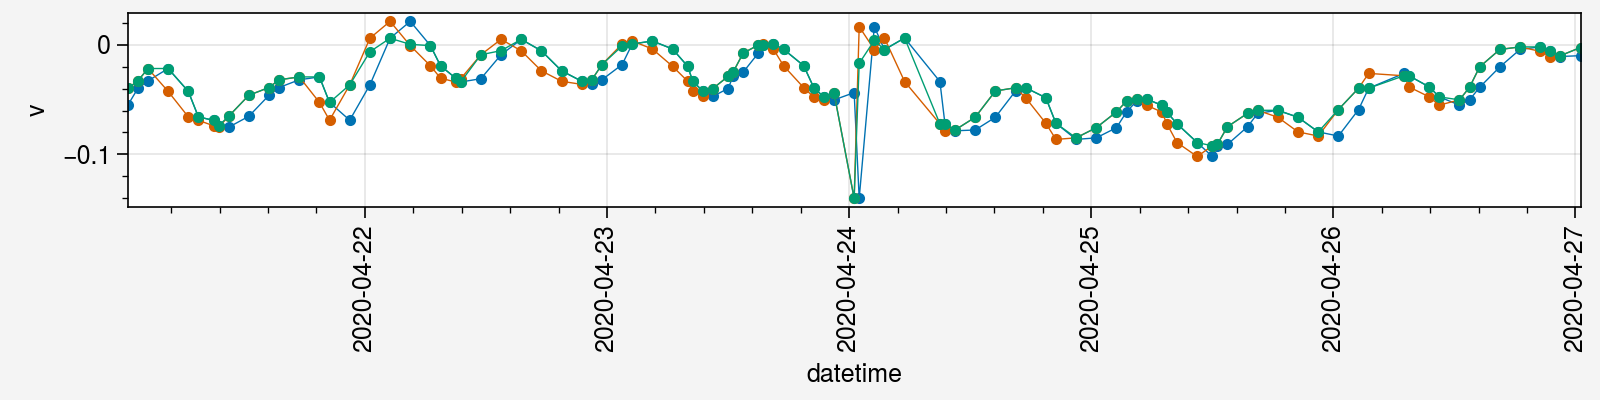

In [694]:
date = f[f].index[0]
dt = pd.to_timedelta('3D')
ts = slice(date - dt, date + dt)
fig, ax= pplt.subplots(proj='npstere')
ax.format(boundinglat=50, land=True)
ax.plot(buoy_df.loc[ts, 'longitude'], buoy_df.loc[ts, 'latitude'], marker='.')

fig, ax = pplt.subplots(width=8, height=2)
for method in ['b', 'f', 'fb']:
    df = anls.compute_velocity(buoy_df, method=method)
    ax.plot(df.v.loc[ts], marker='.', lw=0.5)
#    ax.scatter(zv.loc[ts], c=f.loc[ts], cmap='bwr')
#ax.hist(np.diff(zv), bins=30)

<AxesSubplot:xlabel='datetime'>

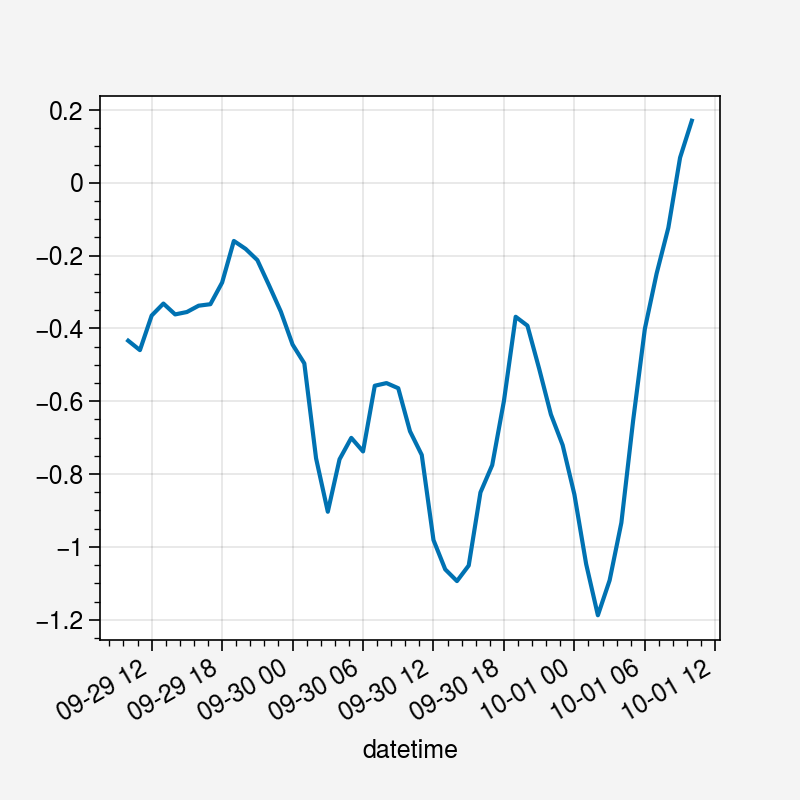

In [655]:
df.u.loc[ts].plot()

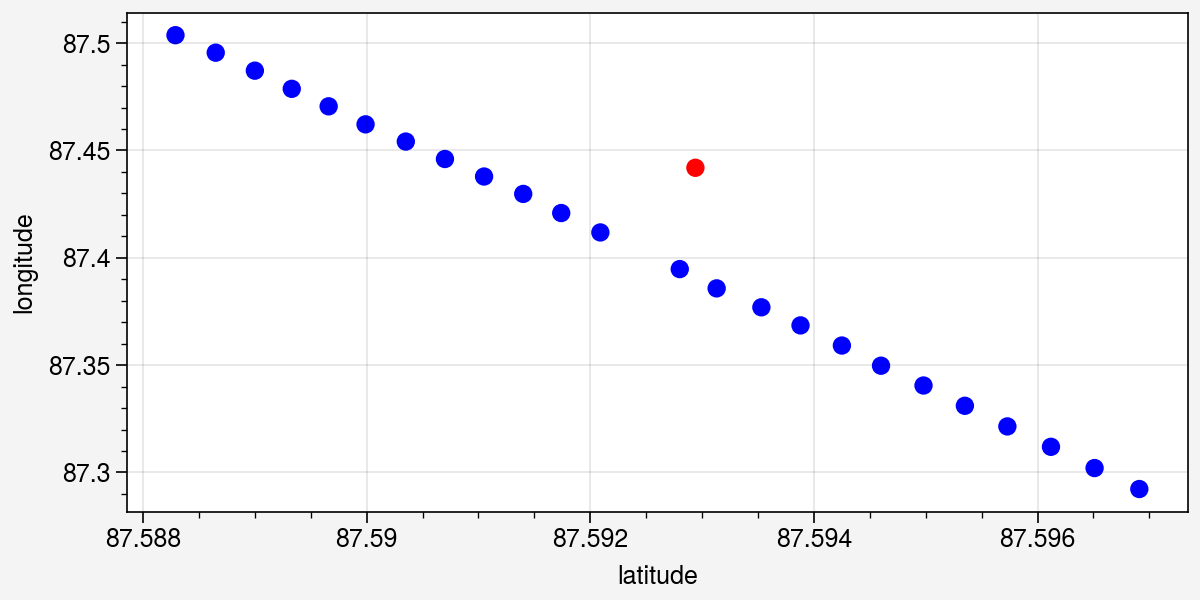

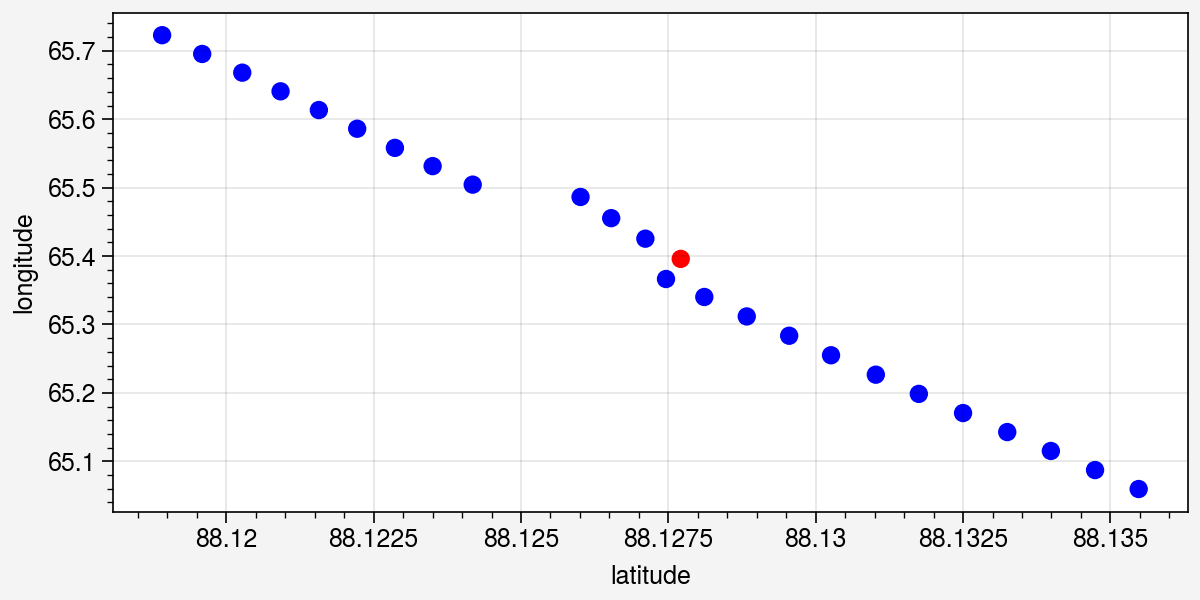

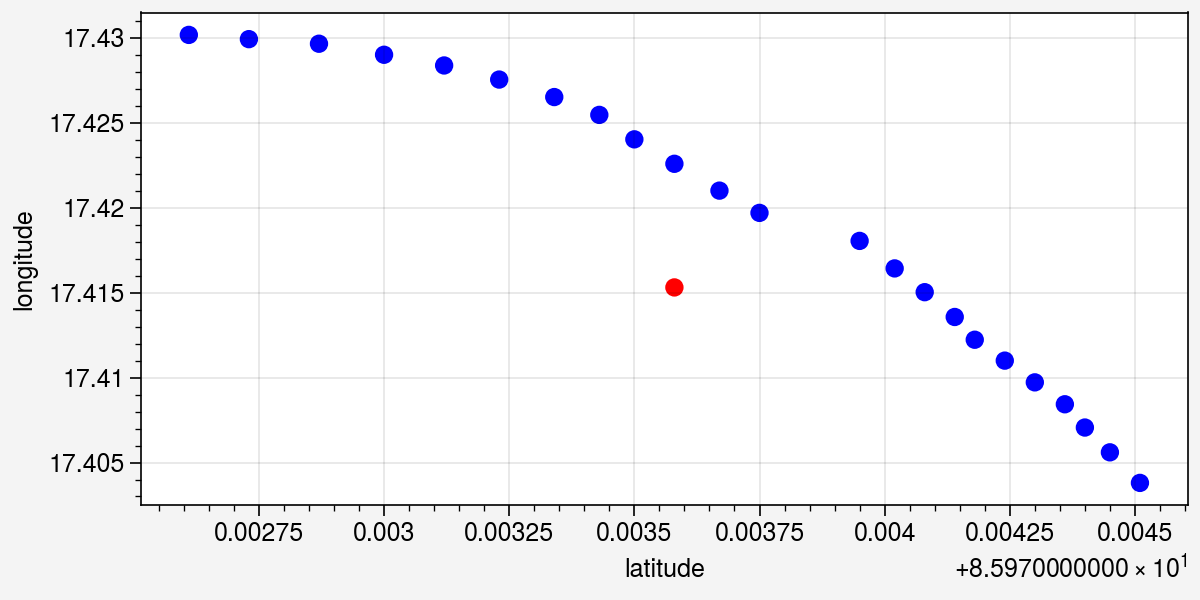

In [470]:
dt = pd.to_timedelta('2H')
for date in f[f].index:
    
    ts = slice(date - dt, date + dt)
    fig, ax = pplt.subplots(width=6, height=3)
    ax.scatter(df.latitude.loc[ts], df.longitude.loc[ts], c=f.loc[ts], cmap='bwr')

    #ax.axvline(date)

In [6]:
metadata = pd.read_csv('../../data/adc_dn_tracks/DN_buoy_list_v2.csv', index_col='Sensor ID')
metadata.loc['2020P224']

Deployment Leg                                                                3
DN Station ID                                                               CO1
IMEI                                                            300234068210190
Deployment Date                                                      2020-03-12
Deployment Datetime                                         2020-03-12 14:00:00
First Data Datetime                                         2020-03-12 14:00:00
Last Data Datetime                                          2020-03-12 17:00:00
Active                                                                        0
Sampling Frequency (hh:mm)                                                01:00
Re-deployed As                                                         2020P227
Formerly Deployed As                                                   2019P153
Buoy Type                                                                   SVP
Manufacturer                            

In [471]:
%%time
raw_data = {}
clean_data = {}

dataloc = '../../data/adc_dn_tracks/'
files = os.listdir(dataloc)
files = [f for f in files if f[0] not in ['.', 'S', 'D']]

for file in files:
    buoy = file.split('_')[-1].replace('.csv', '')
    df = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)
    if 'V' in buoy:
        df.index = df.index - pd.to_timedelta('8H') # Adjust to UTC from Beijing time
    raw_data[buoy] = df

    df_qc = standard_qc(df, min_size=24)
    if df_qc is not None:
        speed_flag = check_speed(df_qc.where(df_qc.flag == 0), window='3D', sigma=5)
        df_qc.flag = speed_flag | df_qc.flag
        
        clean_data[buoy] = df_qc.dropna()
    else:
        print(buoy, 'Less than 24 data points after QC')


2020T60 Less than 24 data points after QC
2019T47 Less than 24 data points after QC
CPU times: user 2min 39s, sys: 472 ms, total: 2min 40s
Wall time: 2min 40s


In [121]:
'V' in '2019V5'

True

# Buoys skipped
| name | reason |
|---|---|  
|CO1_300234068210190_2020P224.csv | Only 4 data points|
|CO1_300234066299840_2020T60.csv | Noisy data + 12-hour sample interval|
|P064_300234064817930_2019T47.csv | 12-hour sample interval |

In [124]:
check_files = [
    'CO1_300234010303850_2020P212.csv',
    'CO1_300234066299840_2020T60.csv',
    'CO1_300234068118580_2019P161.csv',
    'CO1_300234068210190_2019P153.csv',
    'CO1_300234068210190_2020P224.csv',
    'CO1_300434063382860_2019I4.csv',
    'CO1_ASFS50UCB_ASFS50UCB2.csv',
    'CO3_ASFS30UCB_ASFS30UCB4.csv',
    'CO3_ASFS30UCB_ASFS30UCB5.csv',
    'CO3_ASFS50UCB_ASFS50UCB4.csv',
    'CO3_ASFSTUCB_ASFSTUCB3.csv',
    'L1_300025060203170_2019F1.csv',
    'L1_300434063386850_2019I1.csv',
    'L2_300434063384820_2019I2.csv',
    'L3_300434063387850_2019I3.csv',
    'M4_300234066346540_2019S80.csv',
    'M7_300234066081180_2019S95.csv',
    'M7_300234068519770_2019O7.csv',
    'M7_300234068706760_2019T71.csv',
    'M8_300234062788470_2019S90.csv',
    'M8_300234067061400_2019V5.csv',
    'M8_300234068713430_2019O8.csv',
    'P020_300234065982560_2019P145.csv',
    'P033_300234065988570_2019P135.csv',
    'P060_300234062887920_2019P22.csv',
    'P064_300234064817930_2019T47.csv',
    'P078_300234011097770_2020P214.csv',
    'P079_300234011091780_2020P215.csv',
    'P081_300234010082440_2020P210.csv',
    'P082_300234010084660_2020P211.csv',
    'P083_300234062881930_2020P223.csv',
    'P120_300234066087170_2020S109.csv']

In [473]:
for file in check_files:
    b = file.split('_')[-1].replace('.csv', '')
    if b not in clean_data:
        if b in raw_data:
            print(b, len(raw_data[b]))
        else:
            print(b, 'missing')

2020T60 196
2020P224 missing
2019T47 652


In [472]:

for buoy in clean_data:
    fname = '{d}_{i}_{s}.csv'.format(d=metadata.loc[buoy, 'DN Station ID'],
                     i=metadata.loc[buoy, 'IMEI'],
                     s=buoy)
    clean_data[buoy].to_csv('../data/mosaic_qc/' + fname)

In [553]:
%%time
interp_data = {}
for buoy in clean_data:
    df = clean_data[buoy]
    df['flag'] = df['flag'].astype(bool)
    df_speed = anls.compute_velocity(df.where(~df.flag).dropna(), method='fb')    
    df_speed['flag'].fillna(True, inplace=True)
    if df_speed.speed.max() > 1.5:
        df_speed.loc[df_speed.speed > 1.5, 'flag'] = True
    df_speed['flag'].fillna(True, inplace=True)
    
    df_interp = interp.interpolate_buoy_track(df_speed.where(~df_speed.flag).dropna(), maxgap_minutes=240)
    df_interp = anls.compute_velocity(df_interp, method='c')
    interp_data[buoy] = df_interp

CPU times: user 11.2 s, sys: 125 ms, total: 11.3 s
Wall time: 11.3 s


In [588]:
for buoy in interp_data:
    fname = '{d}_{i}_{s}.csv'.format(d=metadata.loc[buoy, 'DN Station ID'],
                     i=metadata.loc[buoy, 'IMEI'],
                     s=buoy)
    interp_data[buoy].to_csv('../data/mosaic_interpolated/' + fname)

<a list of 1 Line2D objects>

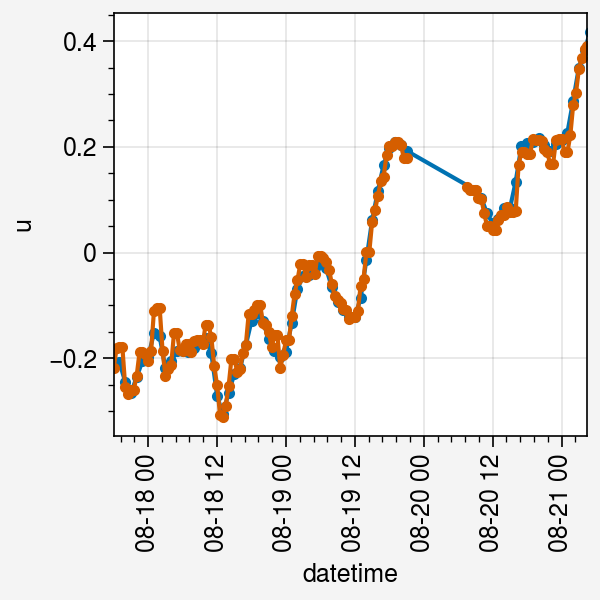

In [605]:
buoy = '2020P218'
df = clean_data[buoy]
df['flag'] = df['flag'].astype(bool)
df_speed = anls.compute_velocity(df.where(~df.flag).dropna(), method='fb')
if df_speed.speed.max() > 1.5:
    df_speed.loc[df_speed.speed > 1.5, 'flag'] = True
df_speed['flag'].fillna(True, inplace=True)

df_interp = interp.interpolate_buoy_track(df_speed.where(~df_speed.flag).dropna(), maxgap_minutes=240)
df_interp = anls.compute_velocity(df_interp, method='c')
ts = slice('2020-08-17 18:00:00', '2020-08-21 05:00:00')
fig, ax = pplt.subplots(width=3, height=3)

ax.plot(df_interp['u'].loc[ts], marker='.')
ax.plot(df_speed['u'].where(~df_speed.flag).loc[ts], marker='.')

Checking interpolation - there's a few cases where the speeds show that there's something wrong

In [591]:
df = pd.DataFrame({buoy: interp_data[buoy]['speed'] for buoy in interp_data})

<a list of 1 Line2D objects>

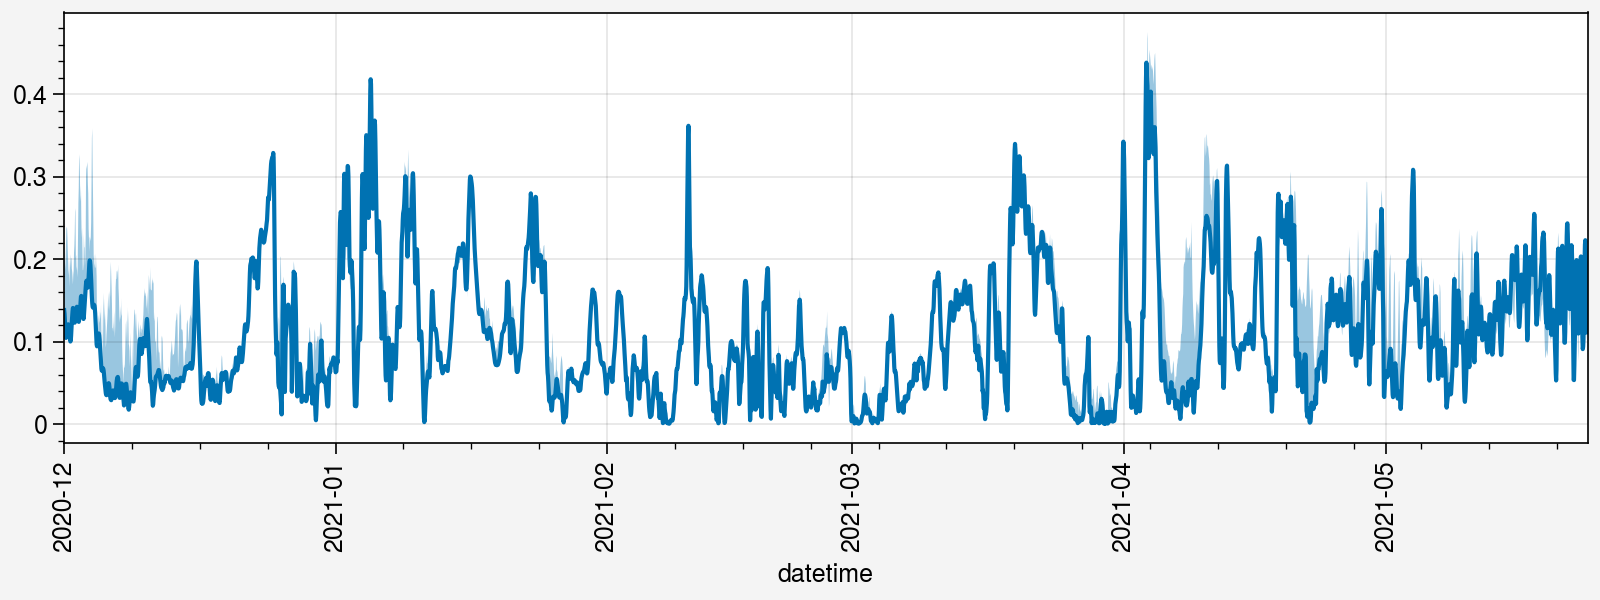

In [600]:
fig, ax = pplt.subplots(width=8, height=3)
ts = slice('2020-12-01', '2021-12-01')
ax.plot(df.loc[ts].median(axis=1), shadedata=[df.loc[ts].quantile(0.75, axis=1), df.loc[ts].quantile(0.25, axis=1)])

In [558]:
for buoy in interp_data:
    if interp_data[buoy].speed.max() > 1.5:
        print(buoy, np.round(interp_data[buoy].speed.max(), 2), interp_data[buoy].speed.idxmax())

2019P151 1.98 2020-10-08 05:00:00
2019P143 1.51 2020-10-13 22:00:00
2019P125 1.56 2020-09-23 13:00:00
2020P225 1.6 2020-10-01 01:00:00
2019P139 1.79 2021-01-26 18:00:00
2019P128 1.53 2020-10-23 09:00:00
2019P157 1.57 2021-04-04 17:00:00
2019P198 1.56 2020-12-01 06:00:00
2019P184 1.52 2020-10-03 05:00:00
2019P127 1.53 2020-12-02 04:00:00
2019P124 1.77 2020-10-31 09:00:00
2020P186 1.65 2020-09-11 13:00:00
2020P185 1.5 2020-11-29 02:00:00
2019P158 1.51 2020-10-11 06:00:00


2019P125
2020P225
2020P186


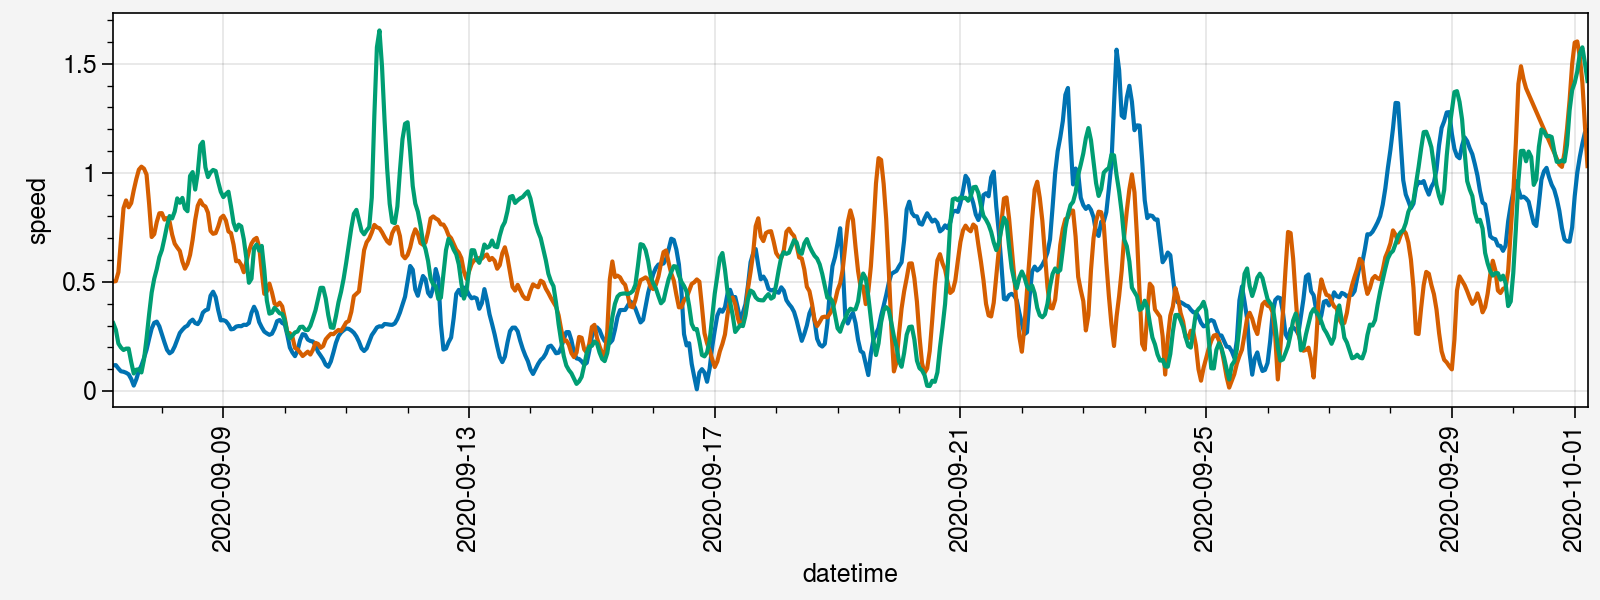

In [561]:
buoy  = '2020P218'
ts = slice('2020-09-07 05:00:00', '2020-10-01 05:00:00')
fig, ax = pplt.subplots(width=8, height=3)
for buoy in interp_data:
    try:     
        if interp_data[buoy]['speed'].loc[ts].max() > 1.5:
            ax.plot(interp_data[buoy]['speed'].loc[ts])
            print(buoy)
    except:
        pass

<AxesSubplot:xlabel='datetime'>

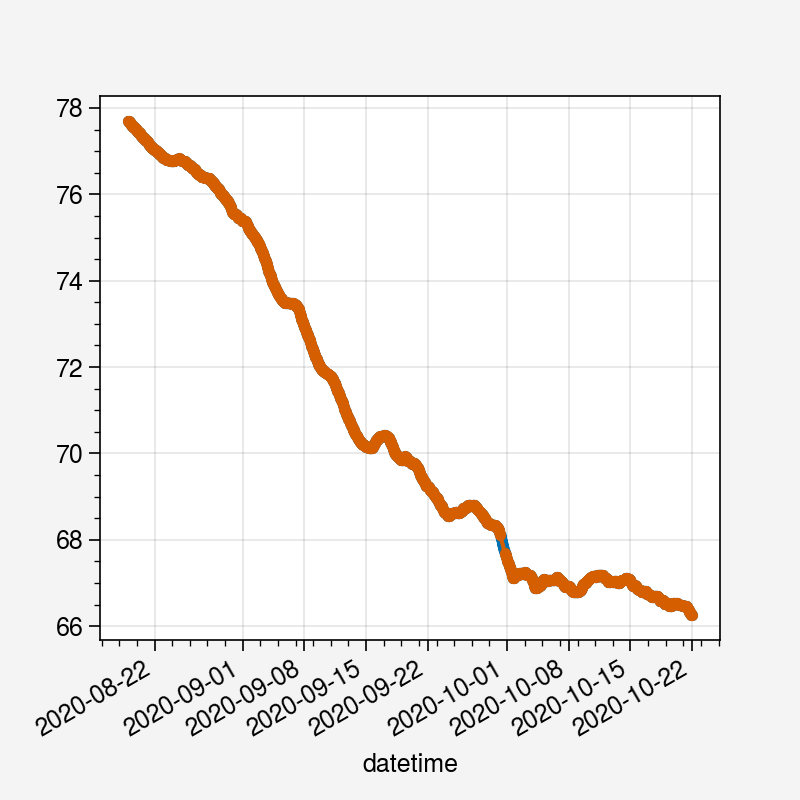

In [563]:
buoy = '2020P225'
df = anls.compute_velocity(clean_data[buoy], method='fb')
ts = slice('2020-08-19', '2020-10-21')
df['latitude'].loc[ts].plot(marker='.')
interp_data[buoy]['latitude'].loc[ts].plot(marker='.')

In [489]:
df['speed'].loc[slice('2019-10-12', '2019-10-14')]

datetime
2019-10-12 00:00:00    0.387636
2019-10-12 03:00:00    0.358191
2019-10-12 06:00:00    0.080645
2019-10-12 09:00:00    0.087309
2019-10-12 12:00:00    0.123253
2019-10-12 15:00:00    0.100475
2019-10-12 18:00:00    0.073373
2019-10-12 21:00:00    0.108972
2019-10-13 00:00:00    0.126694
2019-10-13 03:00:00    0.096752
2019-10-13 06:00:00    0.086043
2019-10-13 09:00:00    0.498648
2019-10-13 12:00:00    0.473392
2019-10-13 15:00:00    0.078392
2019-10-13 18:00:00    0.131915
2019-10-13 21:00:00    0.175467
2019-10-14 00:00:00    0.109014
2019-10-14 03:00:00    0.073192
2019-10-14 06:00:00    0.101967
2019-10-14 09:00:00    0.101194
2019-10-14 12:00:00    0.077703
2019-10-14 15:00:00    0.026817
2019-10-14 18:00:00    0.029167
2019-10-14 21:00:00    0.018102
Name: speed, dtype: float64

In [291]:
cases = pd.DataFrame([['2019P103', '2021-03-01', '2021-05-01'],
                      ['2019P22', '2019-10-10', '2019-10-14', '2019-10-13 12:00:00'],
                      ['2019P206', '2019-10-25', '2019-10-29', '2019-10-26 10:31:57']
                     ],
                    columns=['buoy', 'start', 'end', 'date'])

In [290]:
metadata.loc['2019P206']

Deployment Leg                                                                1
DN Station ID                                                              P016
IMEI                                                            300234068917830
Deployment Date                                                      2019-10-07
Deployment Datetime                                         2019-10-07 07:13:00
First Data Datetime                                         2019-10-07 08:00:26
Last Data Datetime                                          2020-08-29 04:30:24
Active                                                                        0
Sampling Frequency (hh:mm)                                                00:30
Re-deployed As                                                              NaN
Formerly Deployed As                                                        NaN
Buoy Type                                                                   SVP
Manufacturer                            

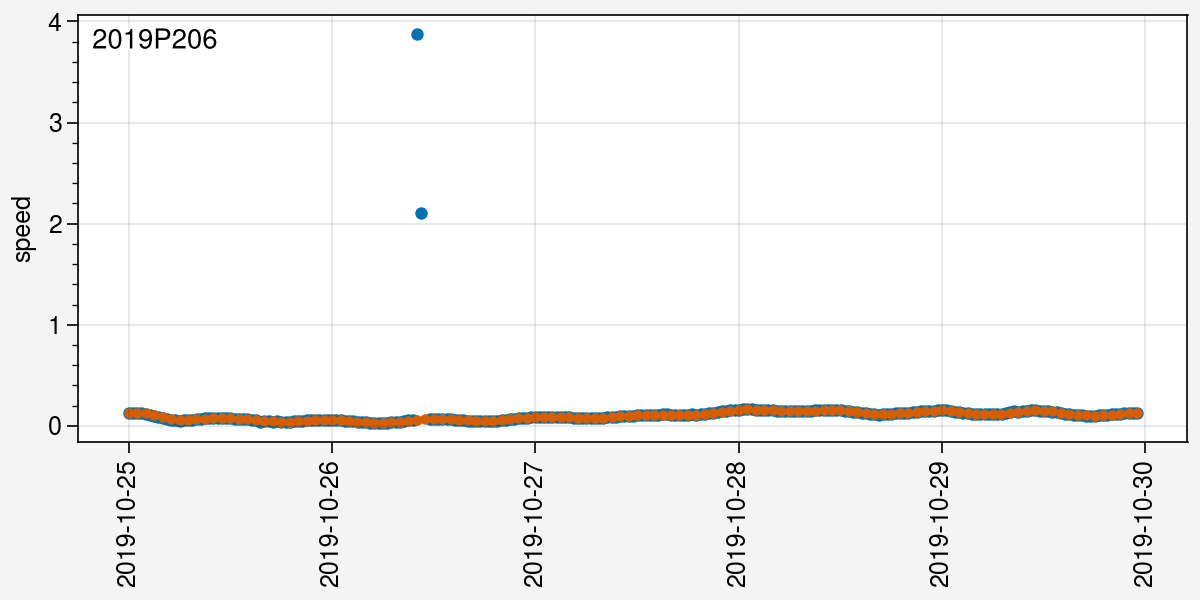

In [564]:
fig, ax = pplt.subplots(width=6, height=3)
idx = 2
buoy, start, end = cases.iloc[idx,:]
ts = slice(start, end)
df = anls.compute_velocity(clean_data[buoy].loc[ts].copy(), method='f')
ax.scatter(df.index,
           df.loc[:, 'speed'], s=15)

ax.scatter(interp_data[buoy].loc[ts].index,
           interp_data[buoy].loc[ts, 'speed'], s=10)
#           c=clean_data[buoy].loc[ts, 'flag'], cmap='bwr')
ax.format(xtickminor=False, xlabel='', ultitle=buoy)
fig.save('../sample/' + buoy + '_qc_flag.jpg')

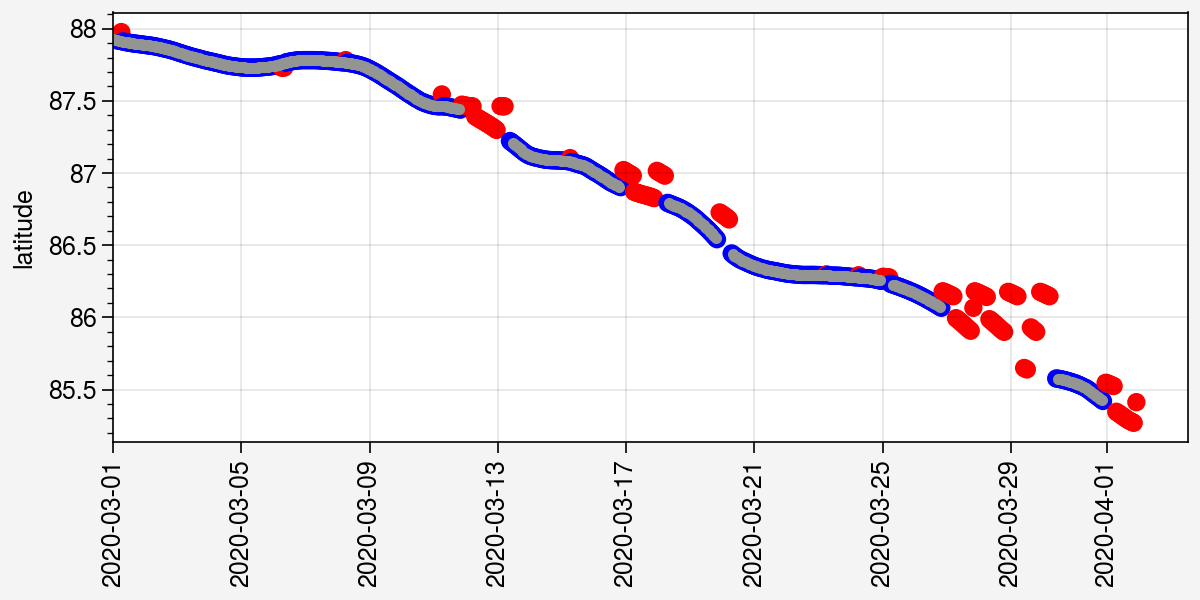

In [568]:
fig, ax = pplt.subplots(width=6, height=3)
buoy = '2019P112'
ts = slice('2020-03-01', '2020-04-01')
ax.scatter(clean_data[buoy].loc[ts, 'longitude'].index,
           clean_data[buoy].loc[ts, 'latitude'],
           c=clean_data[buoy].loc[ts, 'flag'], cmap='bwr')
ax.plot(interp_data[buoy].loc[ts, 'longitude'].index,
        interp_data[buoy].loc[ts, 'latitude'], marker='.', lw=0, c='gray')
ax.format(xtickminor=False, xlabel='')
fig.save('../sample/' + buoy + '_qc_flag.jpg')

In [83]:
%%time
for buoy in clean_data:
    df = clean_data[buoy]
    if np.sum(df.flag == 0) > 24:
        speed_flag = check_speed(df.where(df.flag == 0), window='3D', repeat=5)
        if np.sum(speed_flag) > 0:
            print(len(df), np.sum(df.flag), np.sum(speed_flag))
            clean_data[buoy]['flag'] = df.flag | speed_flag

26918 6698 1
CPU times: user 8.69 s, sys: 62 ms, total: 8.75 s
Wall time: 8.75 s


In [584]:
test_df

,buoy_id,date,variable,value
0,2019R9,2020-04-23 11:01:09,speed,True
1,2019R9,2020-05-17 01:02:20,speed,True
2,2020P171,2020-12-13 00:04:00,speed,True
3,2020P171,2021-01-08 20:04:01,speed,True
4,2020P171,2021-01-08 16:04:02,speed,True
5,2019P178,2021-01-21 13:00:28,speed,True
6,2019P142,2020-04-04 14:30:00,speed,True
7,2019P142,2020-05-25 01:00:00,speed,True
8,2019P142,2020-07-23 00:59:59,speed,True


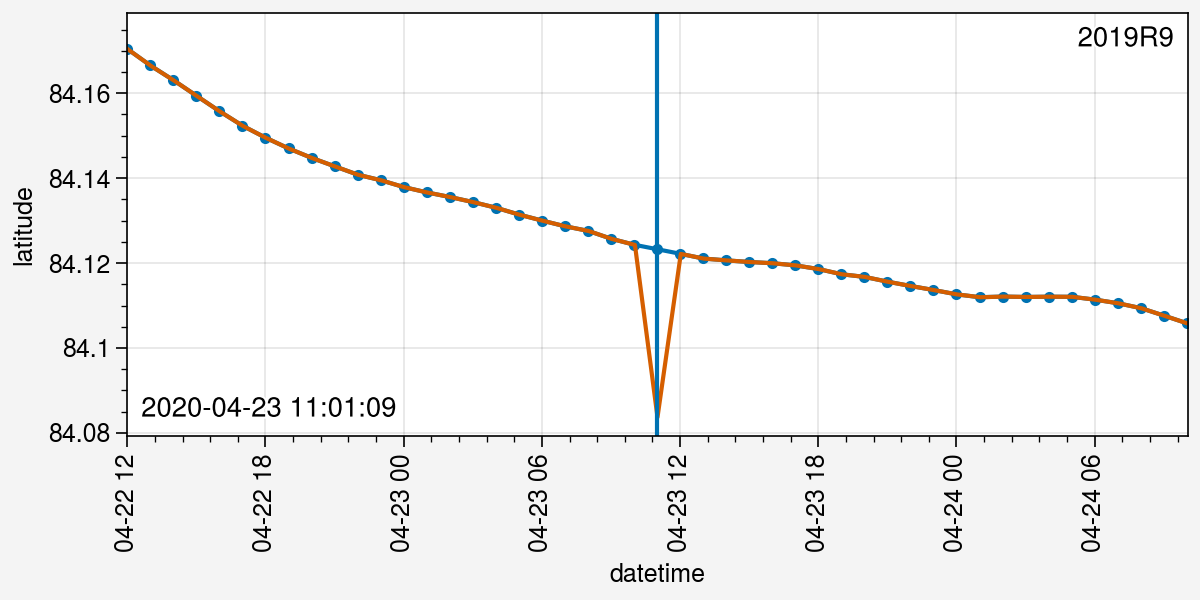

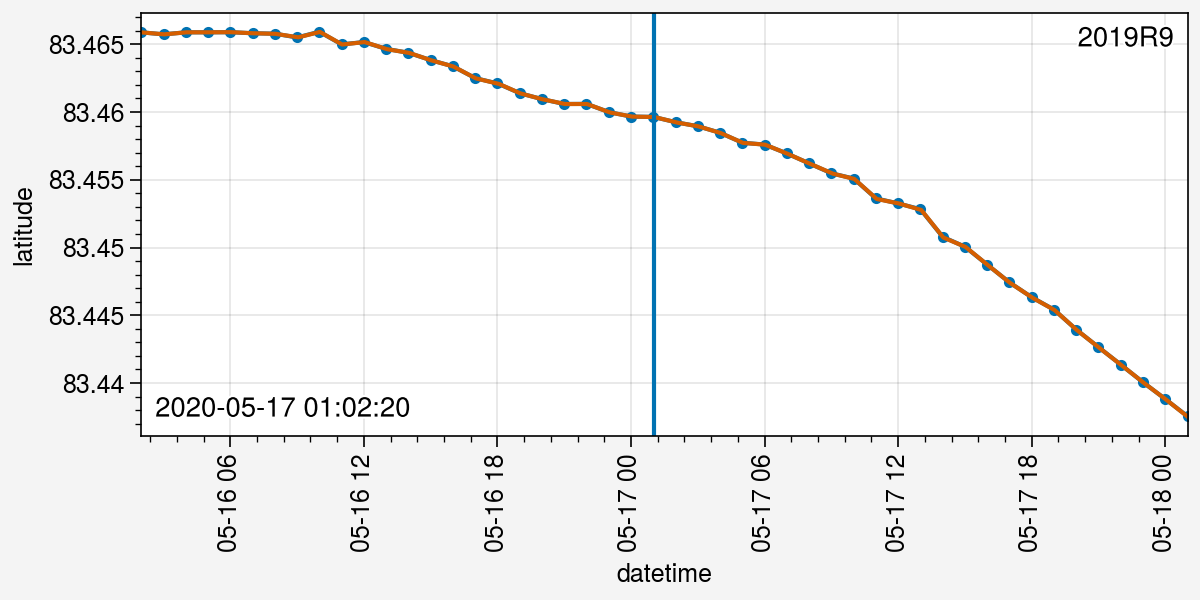

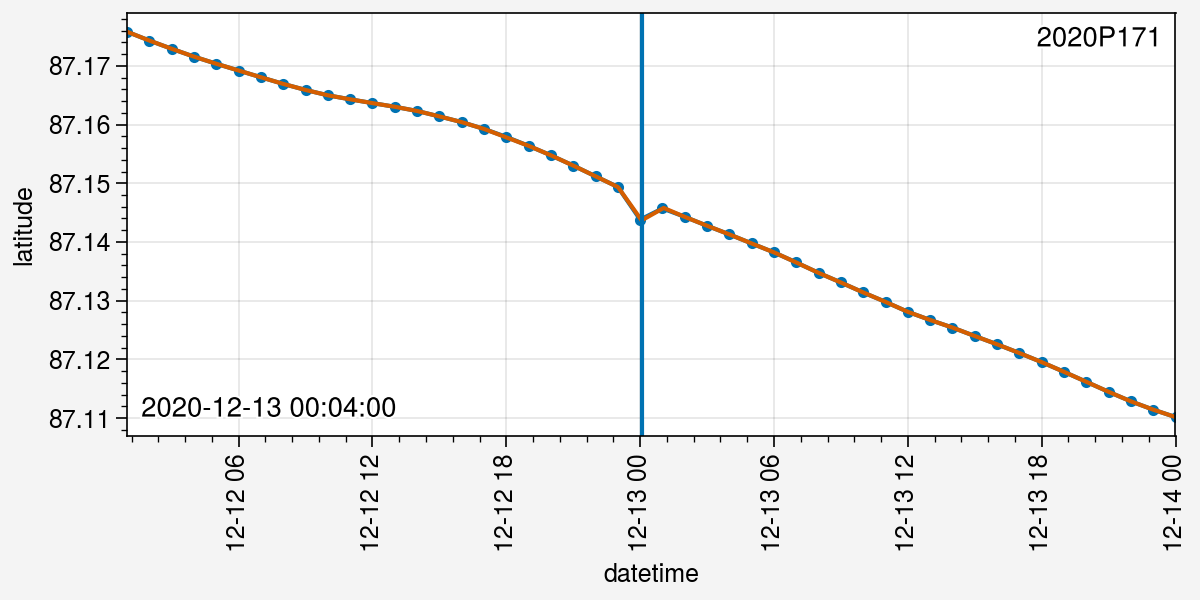

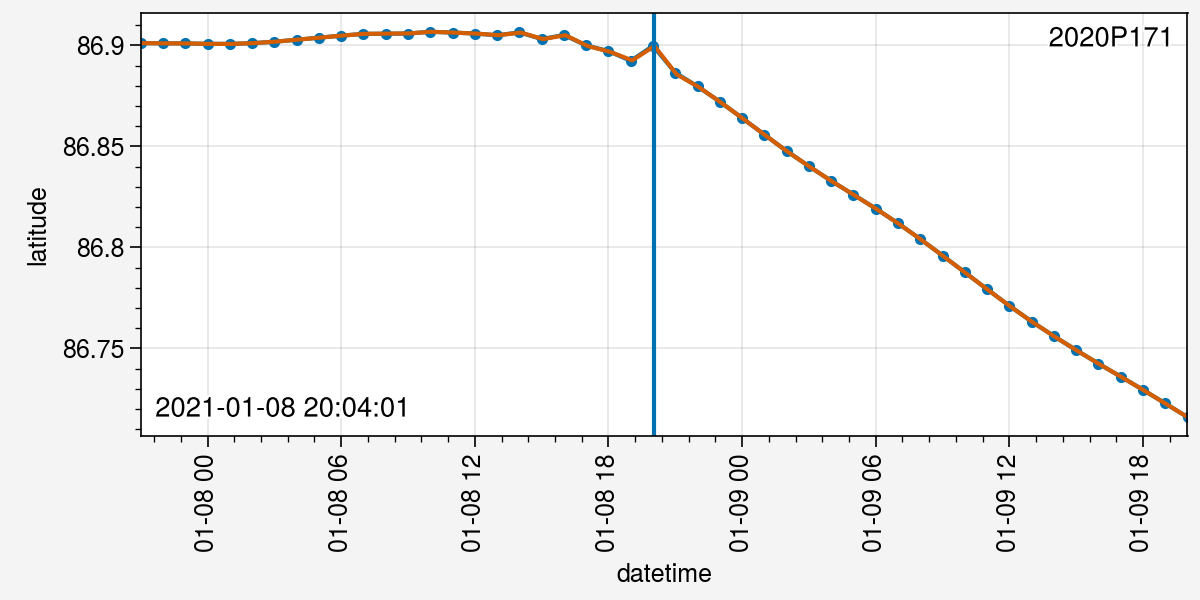

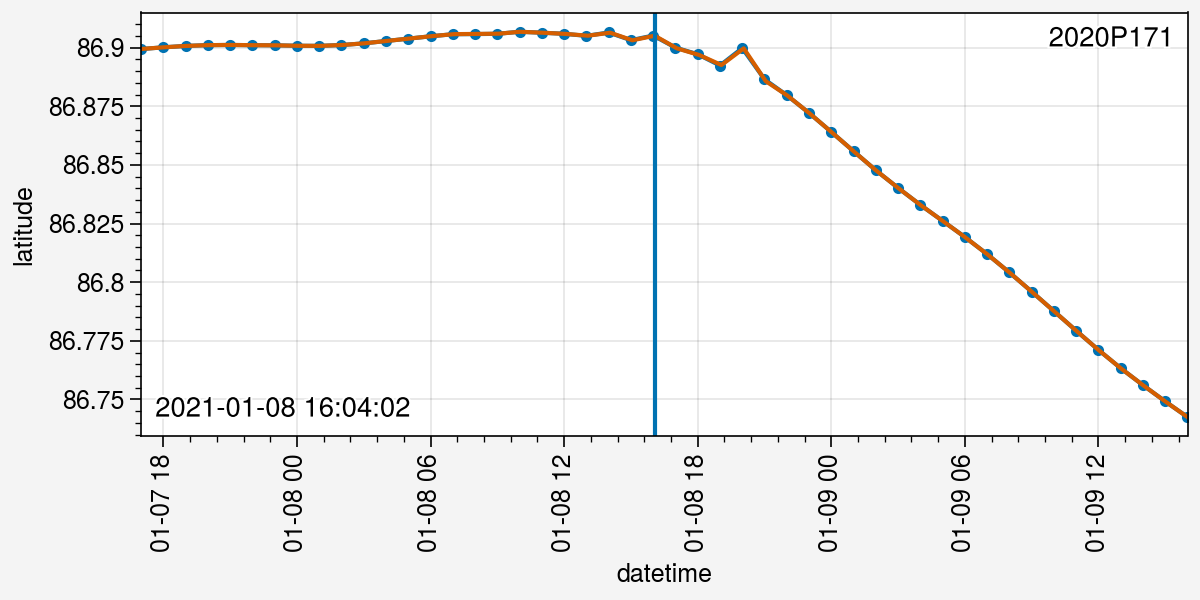

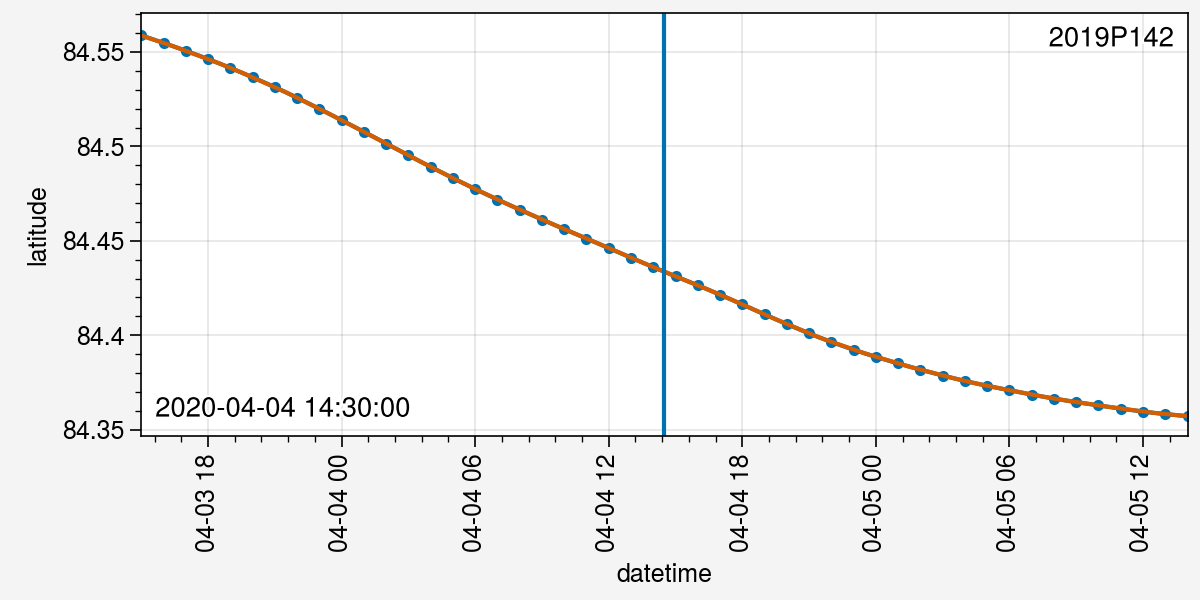

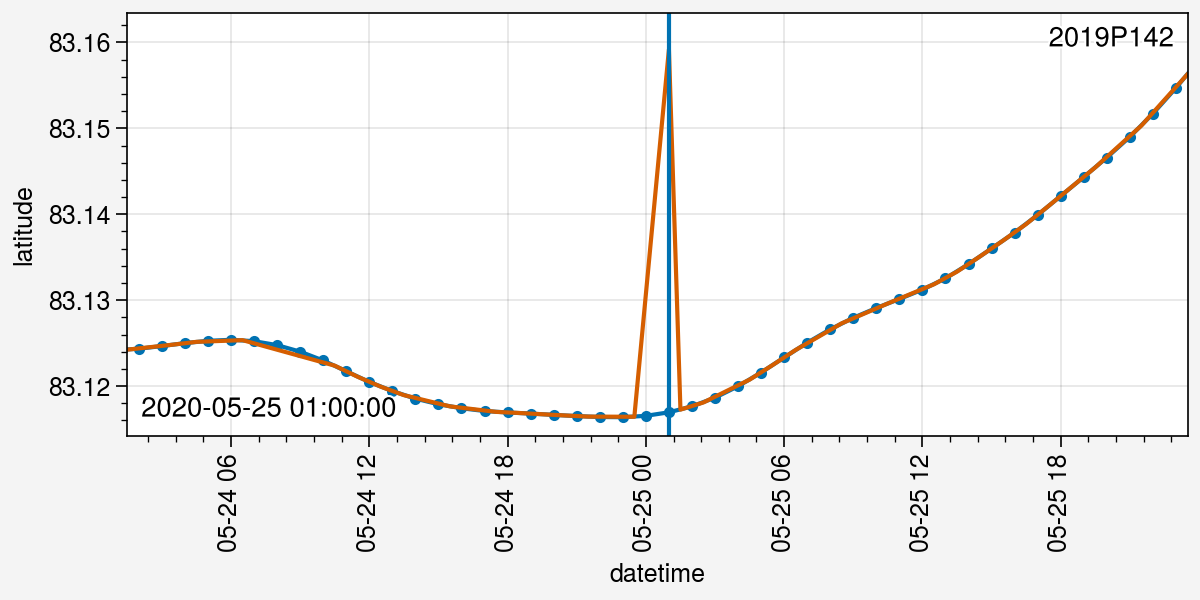

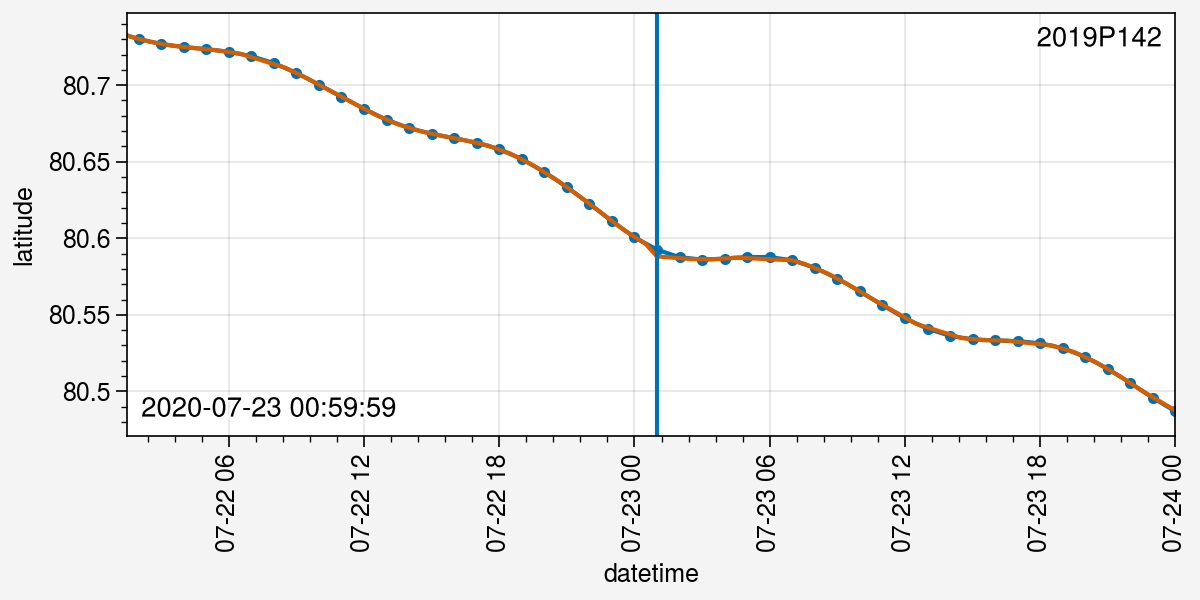

In [587]:
import proplot as pplt
test_df = pd.read_csv('../tests/training_data_mosaic.csv')
test_df['date'] = pd.to_datetime(test_df['date'])
dt = pd.to_timedelta('24H')
for idx in test_df.index:

    buoy = test_df.loc[idx, 'buoy_id']
    if buoy != '2019P178':        
        date = test_df.loc[idx, 'date']
        ts = slice(date - dt, date + dt)
        fig, ax = pplt.subplots(width=6, height=3)
        ax.plot(interp_data[buoy].loc[ts, 'latitude'], marker='.')
        ax.plot(raw_data[buoy].loc[ts, 'latitude'])

        
        ax.axvline(date)
        ax.format(urtitle=buoy, lltitle=date)

In [98]:
clean.check_gaps(clean_data[buoy],
                 threshold_gap='6H',
                 threshold_segment=gap_threshold)

datetime
2020-03-06 23:00:34    False
2020-03-06 23:30:25    False
2020-03-07 00:00:24    False
2020-03-07 00:30:25    False
2020-03-07 01:00:54    False
                       ...  
2020-05-19 17:30:25    False
2020-05-19 18:00:26    False
2020-05-19 18:30:38    False
2020-05-19 19:00:25    False
2020-05-19 19:30:26    False
Length: 2418, dtype: bool

Where I'm leaving off:
- Need to pick method for simple de-spiking that works well enough to reproduce the results for the AGU paper
- Use that version to get the time series set up for the Relative Dispersion paper
- Use some kind of tool to identify when buoys first disperse from each other. SIC should get it most of the way there

In [ ]:
for buoy in interp_data:
    interp_data[buoy].to_csv('')